In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import importlib
from sklearn.base import clone
import config
importlib.reload(config)
from config import BIN_SIZE as bin_size
from config import ANALYSIS_MODE as analysis_mode
from config import SPECIFIC_GROUP as specific_group
from config import STRATIFY_BY as stratify


# 0. Check Config

In [48]:
print(analysis_mode)
print(specific_group)
print(bin_size)

specific_vs_healthy
Gastric cancer
50000


# 1. Loading of Dataframes

In [49]:
matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{bin_size}.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
clinical_df_raw = pd.read_csv(clinical_path, sep=";")

age_at_diagnosis = clinical_df_raw["Age at Diagnosis"]
if analysis_mode == "specific_vs_healthy":
    clinical_df = clinical_df_raw[
            (clinical_df_raw["Patient Type"] == specific_group) |
            (clinical_df_raw["Patient Type"].str.lower() == "healthy")
        ].copy()
else:
    clinical_df = clinical_df_raw.copy()

if stratify =="Gender":
    clinical_df = clinical_df[clinical_df["Gender"].isin(["M", "F"])]
else:
    clinical_df = clinical_df
# Balancing: Sample as many Healthy as there are Cancer samples
cancer_df = clinical_df[clinical_df["Patient Type"].str.lower() != "healthy"]
print(cancer_df.shape)
healthy_df = clinical_df[clinical_df["Patient Type"].str.lower() == "healthy"]
print(healthy_df.shape)
n_cancer = len(cancer_df)

healthy_df = healthy_df.sample(n=n_cancer, random_state=42)
clinical_df = pd.concat([cancer_df, healthy_df]).copy()
print(len(healthy_df))
print(len(cancer_df))

valid_samples = clinical_df["Extracted_ID"].unique()
df = df[df["sample"].isin(valid_samples)].copy()

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")


(24, 19)
(131, 19)
24
24
Number of Samples in Matrix: 48
Number of Bins per Sample: 4260.0


# 2. Pipeline for LASSO

In [50]:
C_values = np.logspace(-4, 4, 50)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso_cv', LogisticRegressionCV(
        Cs=C_values,
        penalty='l1',
        solver='liblinear',
        cv=5,
        scoring='roc_auc',
        max_iter=10000,
        random_state=42
    ))
])

In [51]:
# Add new columns for stratification fpr age and gender
clinical_df["AgeGroup"] = pd.cut(
    clinical_df["Age at Diagnosis"],
    bins=[0, 50, 60, 70, 120],
    labels=["<50", "50-59", "60-69", "70+"]
)


# 3. General Function for LASSO perfomance

In [ ]:
def run_lasso_for_metrics(df, clinical_df, metrics, pipeline, fast=True, stratify="label"):

    # Eine zeile entspricht einem Sample
    pivot_df = df.pivot(index="sample", columns="bin_id", values=list(metrics))
    pivot_df.columns = [f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns]

    # Align clinical data exactly to X: Gleiche reihenfolge wie pivot_df
    clinical_df_sub = (
        clinical_df
        .set_index("Extracted_ID")
        .loc[pivot_df.index]
    )

    # Labels: binäre Klassifikation
    y = (clinical_df_sub["Patient Type"].str.lower() != "healthy").astype(int).values

    # Stratification
    if stratify == "Gender+Age":
        strata = (
            clinical_df_sub["Gender"].astype(str)
            + "_"
            + clinical_df_sub["AgeGroup"].astype(str)
        ).values
    elif stratify == "Gender":
        strata = clinical_df_sub["Gender"].values
    else:
        strata = y

    X = pivot_df

    # Safety check (very recommended)
    assert X.shape[0] == len(y) == len(strata)

    # Split in Training and Test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=0.2, 
        stratify=strata , 
        random_state=42
    )

    if fast:
        # STAGE 1: fast screening
        # less c values 
        fast_lasso = LogisticRegressionCV(
            Cs=15, 
            cv=2, 
            penalty='l1', 
            solver='liblinear', 
            scoring='roc_auc', 
            max_iter=2000, 
            random_state=42
        )
        fast_pipeline = clone(pipeline)
        fast_pipeline.steps[-1] = ('lasso_cv', fast_lasso)
        
        fast_pipeline.fit(X_train, y_train)
        y_prob = fast_pipeline.predict_proba(X_test)[:, 1]

        return {"metrics": metrics, 
                "roc_auc": roc_auc_score(y_test, y_prob)
                }
    
    # STAGE 2: full benchmarking for top 10 combinations
    print(f"  > Full benchmarking for {metrics}...", flush=True)
    
    # 1. 5-Fold Cross Validation for stability analysis
    cv_results = cross_validation(X_train, y_train, pipeline, n_folds=5)
    
    # 2. count stable features (features in all 5 folds selected)
    stability_df = analyze_feature_stability(cv_results)
    n_stable = len(stability_df[stability_df['Frequency'] == 5]) if not stability_df.empty else 0

    # 3. determine the 1SE (Parsimonious) C-value
    pipeline.fit(X_train, y_train)
    lasso_cv = pipeline.named_steps['lasso_cv']
    mean_scores = np.mean(lasso_cv.scores_[1], axis=0)
    std_scores = np.std(lasso_cv.scores_[1], axis=0)
    sem_scores = std_scores / np.sqrt(5)
    
    best_idx = np.argmax(mean_scores)
    best_score = mean_scores[best_idx]
    threshold = best_score - sem_scores[best_idx]
    idx_1se = np.where(mean_scores >= threshold)[0][0]
    c_1se = float(lasso_cv.Cs_[idx_1se])

    # 4. fit simple model (1SE) to calculate the ratio
    stable_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('stable_model', LogisticRegression(
            penalty='l1', 
            solver='liblinear', 
            C=c_1se, 
            max_iter=10000, 
            random_state=42
        ))
    ])
    stable_pipeline.fit(X_train, y_train)

    # 5. extract metrics
    stable_feature_names = set(stability_df[stability_df['Frequency'] == 5]['Feature'])

    pars_feature_names = set(X_train.columns[stable_pipeline.named_steps['stable_model'].coef_[0] != 0])
    pars_overlap = pars_feature_names.intersection(stable_feature_names)
    pars_stability_ratio = len(pars_overlap) / len(pars_feature_names) if len(pars_feature_names) > 0 else 0.0

    simple_feature_names = set(X_train.columns[lasso_cv.coef_[0] != 0])
    simple_overlap = simple_feature_names.intersection(stable_feature_names)
    simple_stability_ratio = len(simple_overlap) / len(simple_feature_names) if len(simple_feature_names) > 0 else 0.0
    
    c_values = [res.get('best_C', np.nan) for res in cv_results]
    c_values = [c for c in c_values if c > 0 and not np.isnan(c)]
    c_variation = np.std(np.log10(c_values)) if len(c_values) > 0 else np.nan
    #Ein Unterschied von 1.0 entspricht einer Zehnerpotenz (z.B. der Sprung von C=0.1 auf C=1.0). 

    y_prob_test = pipeline.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_prob_test)

    return {
        "metrics": metrics,
        "n_features": X.shape[1],
        "n_stable_features": len(stable_feature_names),
        "n_simple_features": len(simple_feature_names),
        "simple_stability_ratio": simple_stability_ratio,
        "n_pars_features": len(pars_feature_names),
        "pars_stability_ratio": pars_stability_ratio,
        "cv_auc": np.mean([e['auc'] for e in cv_results]),
        "test_auc": test_auc,
        "best_C": lasso_cv.C_[0],
        'c_variation': c_variation
    }

'def run_lasso_for_metrics(df, clinical_df, metrics, pipeline, fast=True, stratify="label"):\n\n    # Eine zeile entspricht einem Sample\n    pivot_df = df.pivot(index="sample", columns="bin_id", values=list(metrics))\n    pivot_df.columns = [f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns]\n\n    # Align clinical data exactly to X: Gleiche reihenfolge wie pivot_df\n    clinical_df_sub = (\n        clinical_df\n        .set_index("Extracted_ID")\n        .loc[pivot_df.index]\n    )\n\n    # Labels: binäre Klassifikation\n    y = (clinical_df_sub["Patient Type"].str.lower() != "healthy").astype(int).values\n\n    # Stratification\n    if stratify == "Gender+Age":\n        strata = (\n            clinical_df_sub["Gender"].astype(str)\n            + "_"\n            + clinical_df_sub["AgeGroup"].astype(str)\n        ).values\n    elif stratify == "Gender":\n        strata = clinical_df_sub["Gender"].values\n    else:\n        strata = y\n\n    X = pivot_df\n\n    # Safety chec

# 4. Feature Selektion for LASSO (combinations of metrics)

In [ ]:
### 2. Aktualisierter Loop: Zweistufen-Suche
# Erst schnelles Screening (Stage 1), dann Detail-Analyse der Top 10 (Stage 2).

from cv_lasso_single_fold import cross_validation, analyze_feature_stability, cv_fold_run, print_performance_table, plot_roc_curves, plot_auc_boxplot
df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)
metrics_to_test = ["mean", "median", "stdev", "wps_value", "min", "max"]

print("STAGE 1: Fast Screening (all combinations)", flush=True)
results_fast = []

for r in range(1, len(metrics_to_test) + 1):
    for combination in itertools.combinations(metrics_to_test, r):
        print(f"Screening combo {combination}...", flush=True)
        res = run_lasso_for_metrics(df, clinical_df, combination, pipeline, fast=True)
        results_fast.append(res)
        print(f"  > Fast AUC: {res['roc_auc']:.3f}", flush=True)

# Auswahl der Top 7 nach AUC aus dem Screening
top_10 = pd.DataFrame(results_fast).sort_values("roc_auc", ascending=False).head(10)
print(f"\nTop 10 candidates found. Starting Stage 2 Deep Analysis...", flush=True)

print("\nSTAGE 2: Full Benchmarking Top 10", flush=True)
metrics_results = []
for idx, row in top_10.iterrows():
    combo = row['metrics']
    res = run_lasso_for_metrics(df, clinical_df, combo, pipeline, fast=False)
    metrics_results.append(res)

# Ergebnisse speichern und anzeigen
metrics_results = pd.DataFrame(metrics_results).sort_values("cv_auc", ascending=False)
metrics_results.to_csv(f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/lasso_metrics_results_{specific_group}_{bin_size}.csv", index=False)

print("\n--- FINAL RESULTS (Top 10) ---", flush=True)
display(metrics_results)'''


'from cv_lasso_single_fold import cross_validation, analyze_feature_stability, cv_fold_run, print_performance_table, plot_roc_curves, plot_auc_boxplot\ndf["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)\nmetrics_to_test = ["mean", "median", "stdev", "wps_value", "min", "max"]\n\nprint("STAGE 1: Fast Screening (all combinations)", flush=True)\nresults_fast = []\n\nfor r in range(1, len(metrics_to_test) + 1):\n    for combination in itertools.combinations(metrics_to_test, r):\n        print(f"Screening combo {combination}...", flush=True)\n        res = run_lasso_for_metrics(df, clinical_df, combination, pipeline, fast=True)\n        results_fast.append(res)\n        print(f"  > Fast AUC: {res[\'roc_auc\']:.3f}", flush=True)\n\n# Auswahl der Top 7 nach AUC aus dem Screening\ntop_10 = pd.DataFrame(results_fast).sort_values("roc_auc", ascending=False).head(10)\nprint(f"\nTop 10 candidates found. Starting Stage 2 Deep Analysis...", flush=True)\n\nprint("\nSTAGE 2: Full Benchmarking 

In [54]:
#metrics_results.to_csv(f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/lasso_metrics_results_PanCancer_{bin_size}.csv", index=False)


In [ ]:
'''filtered = metrics_results[
   (metrics_results['pars_stability_ratio'] >= 0.1)&
    (metrics_results['simple_stability_ratio'] >= 0.1)&
    (metrics_results['cv_auc'] >= 0.7)&
    (metrics_results['test_auc'] >= 0.7)&
    (metrics_results['c_variation'] <= 1)
]
print(filtered)

# nehme die kombi dessen metric anzahl die wenigstens metriken hat, also bevorzuge eine kombi mit 1 metric vor einer kombi mit 2 metriken etc.
filtered = filtered.copy()
filtered["n_metrics"] = filtered["metrics"].apply(len)
filtered = filtered.sort_values(
    by=["n_metrics", "cv_auc"],  # optional: AUC als Tie-Breaker
    ascending=[True, False]
)
best_metrics = filtered.iloc[0]["metrics"]
print("Final Metric Combination:", best_metrics)


'filtered = metrics_results[\n   (metrics_results[\'pars_stability_ratio\'] >= 0.1)&\n    (metrics_results[\'simple_stability_ratio\'] >= 0.1)&\n    (metrics_results[\'cv_auc\'] >= 0.7)&\n    (metrics_results[\'test_auc\'] >= 0.7)&\n    (metrics_results[\'c_variation\'] <= 1)\n]\nprint(filtered)\n\n# nehme die kombi dessen metric anzahl die wenigstens metriken hat, also bevorzuge eine kombi mit 1 metric vor einer kombi mit 2 metriken etc.\nfiltered = filtered.copy()\nfiltered["n_metrics"] = filtered["metrics"].apply(len)\nfiltered = filtered.sort_values(\n    by=["n_metrics", "cv_auc"],  # optional: AUC als Tie-Breaker\n    ascending=[True, False]\n)\nbest_metrics = filtered.iloc[0]["metrics"]\nprint("Final Metric Combination:", best_metrics)'

# 5. Influence of metric selection on model performance

In [56]:
'''metrics_results.groupby("n_metrics")["roc_auc"].mean().plot(
    title="Mean ROC AUC vs Number of Metrics",
    ylabel="ROC AUC",
    xlabel="Number of Metrics"
)'''#

'metrics_results.groupby("n_metrics")["roc_auc"].mean().plot(\n    title="Mean ROC AUC vs Number of Metrics",\n    ylabel="ROC AUC",\n    xlabel="Number of Metrics"\n)'

### 5.1 Lasso Modeling with best C parameter 

The `LogisticRegressionCV` model automatically tried out different values for the parameter `C`. 
Here we visualize how the accuracy of the model changes with `C`.

- **Small C**: Strong regularization (model is “forced” to find simple solutions). Risk of underfitting.
- **Large C**: Weak regularization (model can be more complex). Risk of overfitting.
- **Best C**: The value that achieved the best balance and thus the highest score in cross-validation (CV).

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

Re-training model with best metrics: ['mean', 'stdev']
        sample    group chrom  bin        mean      median      stdev  \
68160  EE85904  healthy  chr1   18  170.681086  169.210955  17.356366   
68161  EE85904  healthy  chr1   21  171.278786  171.193574  19.074607   
68162  EE85904  healthy  chr1   23  173.193801  172.457134  16.892684   
68163  EE85904  healthy  chr1   25  169.176392  167.892596  14.518660   
68164  EE85904  healthy  chr1   26  171.587770  170.405779  18.170460   

              min         max  wps_value    start      end       GC  \
68160  108.735404  209.802887  -0.429810   900000   950000  0.63236   
68161  131.894471  247.517735  -0.056738  1050000  1100000  0.62400   
68162  125.137704  217.731431   0.110368  1150000  1200000  0.59202   
68163  129.326279  207.191266   0.011599  1250000  1300000  0.60030   
68164  125.137824  227.923146   0.182478  1300000  1350000  0.64590   

             bin_id  
68160   chr1_900000  
68161  chr1_1050000  
68162  chr1_1

Best C (max mean): 10000.000000 with AUC: 0.8208
c_1se (parsimonious): 109.854114 (Threshold: 0.7401)
Fold 1/5...
  AUC = 0.562, Best C = 6866.488450042998
Fold 2/5...
  AUC = 0.750, Best C = 5.428675439323859
Fold 3/5...
  AUC = 0.500, Best C = 1526.4179671752302
Fold 4/5...
  AUC = 0.833, Best C = 1526.4179671752302
Fold 5/5...
  AUC = 0.833, Best C = 10000.0
pars_stability_ratio: 0.049429657794676805
simple_stability_ratio: 0.0053674649050371595


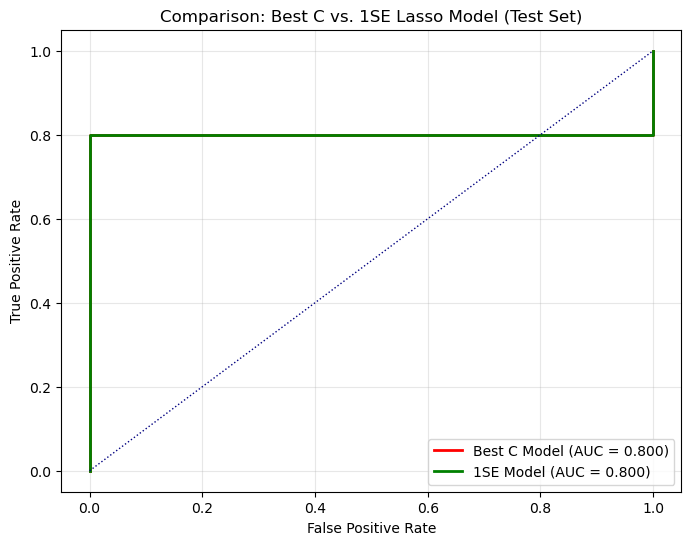

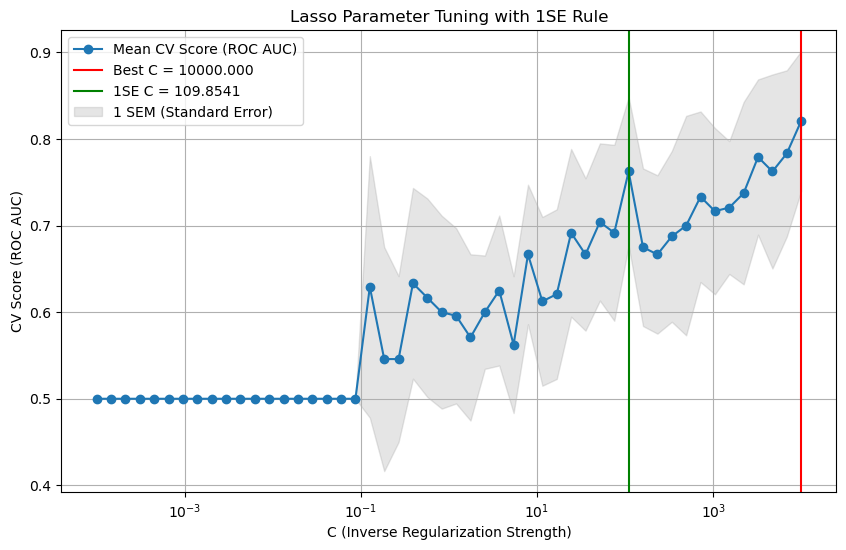

In [ ]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability

#best_metrics = ['mean', 'stdev']
print(f"Re-training model with best metrics: {best_metrics}")

df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)
print(df.head())
# Pivot
pivot_df = df.pivot(
    index="sample",
    columns="bin_id",
    values=list(best_metrics)
)
pivot_df.columns = [
    f"{metric}_{bin_id}" for metric, bin_id in pivot_df.columns
]

# Labels
y = []
strata = []
for sample_id in pivot_df.index:
    row = clinical_df[clinical_df["Extracted_ID"] == sample_id].iloc[0]
    is_healthy = row["Patient Type"].lower() == "healthy"
    target_val = 0 if is_healthy else 1
    y.append(target_val)
    if stratify == "Gender":
        strata.append(row["Gender"])
    else:
        strata.append(target_val)

y = np.array(y)
X = pivot_df
n_nans = X.isna().sum().sum()
if n_nans > 0:
    print(f"{n_nans} NaNs found in dataframe")

else:
    print("No NaNs in dataframe")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=strata,
    random_state=42,
)


# Fit
pipeline.fit(X_train, y_train)

lasso_cv = pipeline.named_steps["lasso_cv"]


# --- 1se Rule Calculation ---
# scores_[1] is of shape (n_folds, n_Cs)
mean_scores = np.mean(lasso_cv.scores_[1], axis=0)
std_scores = np.std(lasso_cv.scores_[1], axis=0)
n_folds = 5
sem_scores = std_scores / np.sqrt(n_folds)
cs = lasso_cv.Cs_

best_idx = np.argmax(mean_scores)
best_c = float(cs[best_idx])
best_score = mean_scores[best_idx]
best_sem = sem_scores[best_idx]
threshold = best_score - best_sem

# c_1se: smallest C (most parsimonious) within 1 SEM of maximum
idx_1se = np.where(mean_scores >= threshold)[0][0]
c_1se = float(cs[idx_1se])

print(f"Best C (max mean): {best_c:.6f} with AUC: {best_score:.4f}")
print(f"c_1se (parsimonious): {c_1se:.6f} (Threshold: {threshold:.4f})")


# --- STABILERES MODELL MIT C_1SE ---

stable_lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=c_1se,
    max_iter=10000,
    random_state=42
)

stable_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', stable_lasso)
])

stable_pipeline.fit(X_train, y_train)
# 1. Calculate probabilities for both models (Test Set)
y_prob_best = pipeline.predict_proba(X_test)[:, 1]
y_prob_1se = stable_pipeline.predict_proba(X_test)[:, 1]

# 2. Calculate ROC values for both models
fpr_best, tpr_best, _ = roc_curve(y_test, y_prob_best)
fpr_1se, tpr_1se, _ = roc_curve(y_test, y_prob_1se)

auc_best = roc_auc_score(y_test, y_prob_best)
auc_1se = roc_auc_score(y_test, y_prob_1se)

# 1. 5-Fold Cross Validation for stability analysis
cv_results = cross_validation(X_train, y_train, pipeline, n_folds=5)
    
# 2. count stable features (features in all 5 folds selected)
stability_df = analyze_feature_stability(cv_results)
stable_feature_names = set(stability_df[stability_df['Frequency'] == 5]['Feature'])

pars_feature_names = set(X_train.columns[stable_pipeline.named_steps['model'].coef_[0] != 0])
pars_overlap = pars_feature_names.intersection(stable_feature_names)
pars_stability_ratio = len(pars_overlap) / len(pars_feature_names) if len(pars_feature_names) > 0 else 0.0
print(f"pars_stability_ratio: {pars_stability_ratio}")

simple_feature_names = set(X_train.columns[lasso_cv.coef_[0] != 0])
simple_overlap = simple_feature_names.intersection(stable_feature_names)
simple_stability_ratio = len(simple_overlap) / len(simple_feature_names) if len(simple_feature_names) > 0 else 0.0
print(f"simple_stability_ratio: {simple_stability_ratio}")


# 3. Create Common Plot
plt.figure(figsize=(8, 6))

# Curve 1: Best C (e.g., in Blue)
plt.plot(fpr_best, tpr_best, color='red', lw=2, 
         label=f'Best C Model (AUC = {auc_best:.3f})')

# Kurve 2: 1SE Model (z.B. in Grün oder Orange)
plt.plot(fpr_1se, tpr_1se, color='green', lw=2,
         label=f'1SE Model (AUC = {auc_1se:.3f})')

# Diagonale (Zufallslinie)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle=':')

plt.title('Comparison: Best C vs. 1SE Lasso Model (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.show()

# --- Lasso Parameter Tuning Plot ---
plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - sem_scores, mean_scores + sem_scores, alpha=0.2, color='gray', label='1 SEM (Standard Error)')
plt.axvline(best_c, color='r', label=f'Best C = {best_c:.3f}')
plt.axvline(c_1se, color='g', label=f'1SE C = {c_1se:.4f}')
plt.title("Lasso Parameter Tuning with 1SE Rule")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/lasso_parameter_tuning{bin_size}.png")
plt.show()

## 5.2 Training vs. Test with best model 

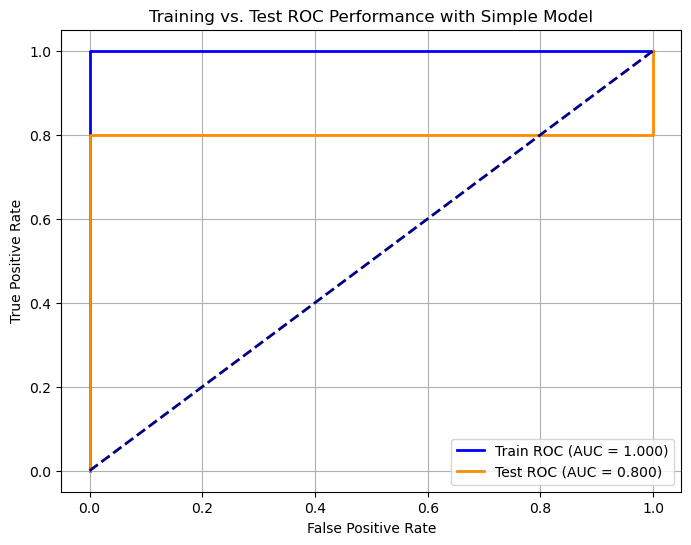

In [58]:
y_prob_train = pipeline.predict_proba(X_train)[:, 1]
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.3f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Simple Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 5.3 Training vs. Test with 1SE Model

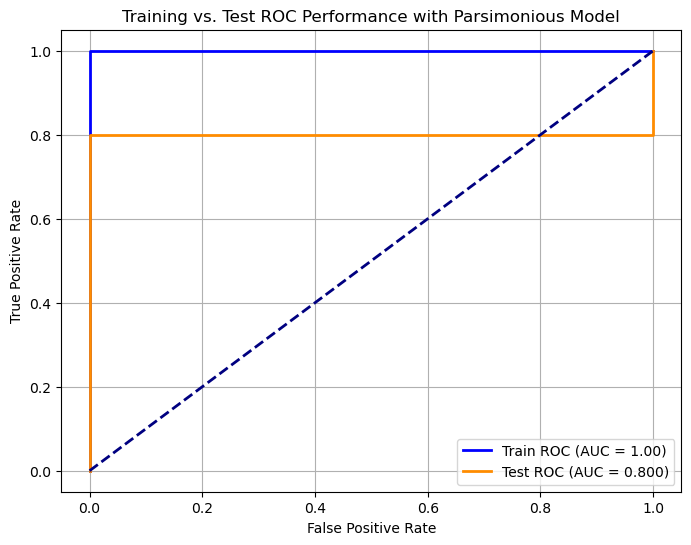

In [59]:
y_prob_train = stable_pipeline.predict_proba(X_train)[:, 1]
y_prob_test = stable_pipeline.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)

auc_train = roc_auc_score(y_train, y_prob_train)
auc_test = roc_auc_score(y_test, y_prob_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Parsimonious Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 6. Selected Important Features


## 6.1 Pipeline with best model

                Feature  Coefficient
0     mean_chr10_100000    -0.000590
1  mean_chr10_100950000    -0.013898
2  mean_chr10_101050000     0.055627
3  mean_chr10_101400000     0.000000
4  mean_chr10_101550000     0.000000
SINGLE MODEL (Best C)
Number of Important Features (Best Model): 2422

Top Features (Best Model - Positive = Indicative for Cancer):


<AxesSubplot:title={'center':'Top Features (Best Model - Positive = Indicative for Cancer)'}, ylabel='Feature'>

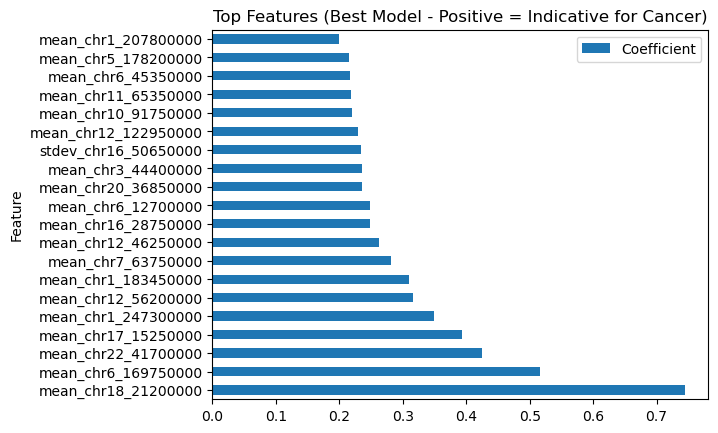

In [60]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, plot_roc_curves, plot_auc_boxplot

lasso_model = pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lasso_model.coef_[0]
})
print(coef_df.head())
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("SINGLE MODEL (Best C)")
print(f"Number of Important Features (Best Model): {len(important_features)}")
print("\nTop Features (Best Model - Positive = Indicative for Cancer):")
important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Best Model - Positive = Indicative for Cancer)")


## 6.2 Stable Pipeline with 1SE model 


STABLE MODEL (c_1se):
Number of Important Features (Stable Model): 263

Top Features (Stable Model - Positive = Indicative for Cancer):


COMPARISON:
Best C Model: 2422 features selected
1SE Model:    263 features selected
Difference:   2159 fewer features in 1SE model
stable_important_features:                    Feature  Coefficient
1444   mean_chr17_73200000     0.483396
3147   mean_chr4_145900000     0.467306
1249   mean_chr16_88950000     0.462098
969    mean_chr15_42450000     0.371582
3470   mean_chr6_104900000     0.361769
...                    ...          ...
5457  stdev_chr16_67200000    -0.301668
2889   mean_chr3_113200000    -0.311758
6324  stdev_chr1_206300000    -0.348540
6382  stdev_chr1_235300000    -0.362169
1244   mean_chr16_88500000    -0.399372

[263 rows x 2 columns]


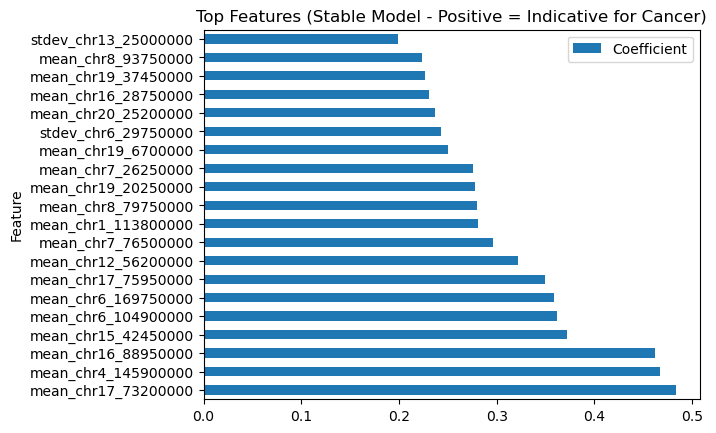

In [61]:

stable_lasso_model = stable_pipeline.named_steps['model']

stable_coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": stable_lasso_model.coef_[0]
})

stable_important_features = stable_coef_df[stable_coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("STABLE MODEL (c_1se):")
print(f"Number of Important Features (Stable Model): {len(stable_important_features)}")
print(f"\nTop Features (Stable Model - Positive = Indicative for Cancer):")
stable_important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Stable Model - Positive = Indicative for Cancer)")

print("\n")
print("COMPARISON:")
print(f"Best C Model: {len(important_features)} features selected")
print(f"1SE Model:    {len(stable_important_features)} features selected")
print(f"Difference:   {len(important_features) - len(stable_important_features)} fewer features in 1SE model")

print(f"stable_important_features: {stable_important_features}")

# 7. Feature Stability Analysis (Cross-Validation) 


Running 5-Fold Cross-Validation for Feature Stability.
Fold 1/5...


  AUC = 0.562, Best C = 6866.488450042998
Fold 2/5...
  AUC = 0.750, Best C = 5.428675439323859
Fold 3/5...
  AUC = 0.500, Best C = 1526.4179671752302
Fold 4/5...
  AUC = 0.833, Best C = 1526.4179671752302
Fold 5/5...
  AUC = 0.833, Best C = 10000.0


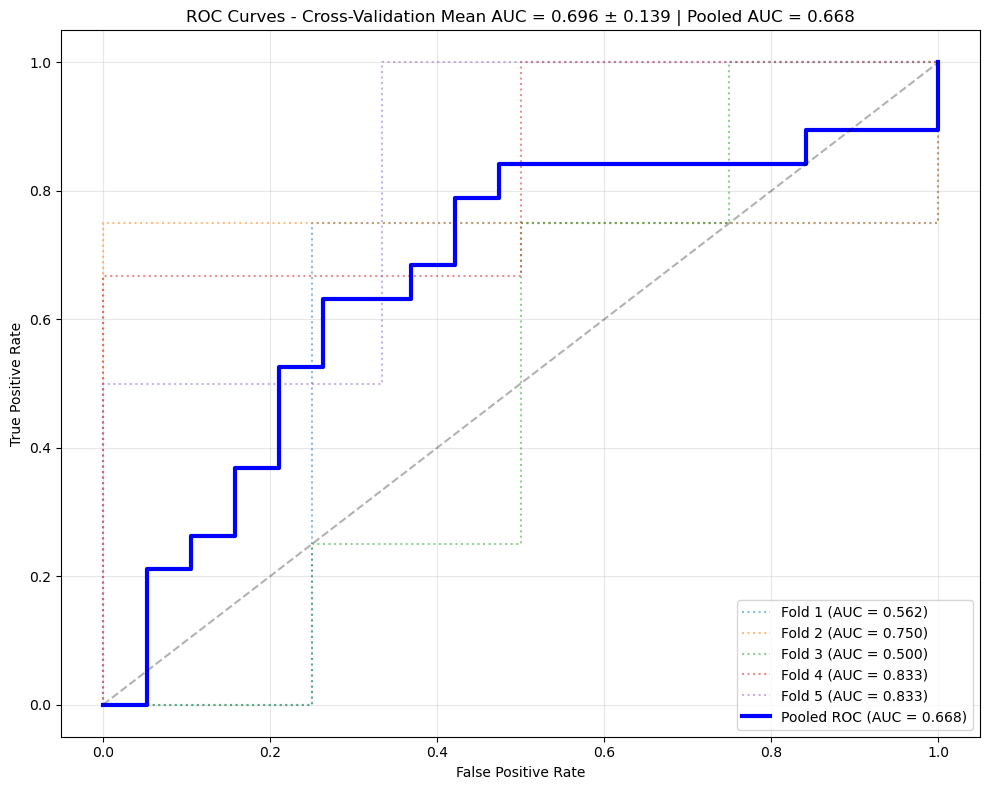

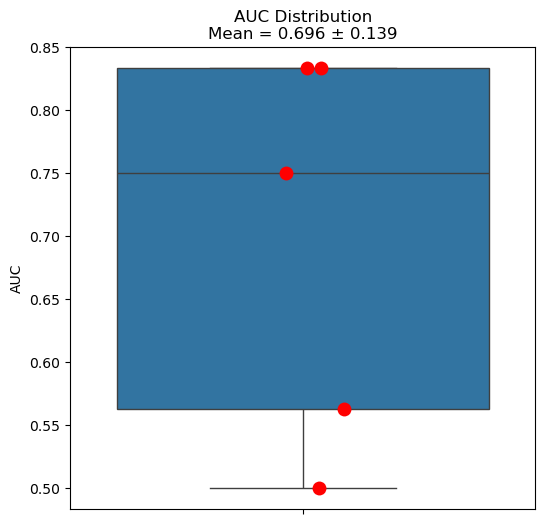

In [62]:
import importlib
import cv_lasso_single_fold
importlib.reload(cv_lasso_single_fold)
from cv_lasso_single_fold import plot_roc_curves
print("Running 5-Fold Cross-Validation for Feature Stability.")

# X and y should be available from previous cells. 
# We use X (full pivot_df before split if available, or regenerate if needed).
# Assuming X and y are the full datasets as defined before train_test_split.

# Re-verify label consistency
# hier macht es keinen sinn die stable pipeline zu nutzen, da in jedem fold mit dem gleichen c wert (c_1se) trainiert wird
cv_results = cross_validation(X_train, y_train, pipeline, n_folds=5)

# Plotte Performance
plot_roc_curves(cv_results)
plot_auc_boxplot(cv_results)


## 7.2 Table with Statistical Values

In [63]:
from cv_lasso_single_fold import print_performance_table
stat_table = print_performance_table(cv_results)
print(stat_table)

'''
Accuracy: Anteil korrekt klassifizierter Samples
Sensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)
Specificity: Wie viele Gesunde wurden korrekt erkannt
Precision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs
'''


   Fold       AUC  Accuracy  Sensitivity  Specificity  Precision  \
0     1  0.562500  0.625000     0.500000     0.750000   0.666667   
1     2  0.750000  0.875000     0.750000     1.000000   1.000000   
2     3  0.500000  0.500000     0.500000     0.500000   0.500000   
3     4  0.833333  0.571429     0.666667     0.500000   0.500000   
4     5  0.833333  0.714286     0.750000     0.666667   0.750000   
5  Mean  0.695833  0.657143     0.633333     0.683333   0.683333   
6   Std  0.155624  0.144742     0.126381     0.207498   0.207498   

         Best_C   N_Features  
0   6866.488450  1004.000000  
1      5.428675    69.000000  
2   1526.417967   295.000000  
3   1526.417967   352.000000  
4  10000.000000  2104.000000  
5   3984.950612   764.800000  
6   4254.686822   825.519049  


'\nAccuracy: Anteil korrekt klassifizierter Samples\nSensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)\nSpecificity: Wie viele Gesunde wurden korrekt erkannt\nPrecision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs\n'

## 7.3 Feature Stability Analyse



Top Stable Features (Selected across multiple folds):
                  Feature  Frequency  Frequency_Percent  Mean_Coef
200   mean_chr16_88950000          5              100.0   0.231971
569   mean_chr6_104900000          5              100.0   0.214082
235   mean_chr17_73200000          5              100.0   0.206483
521   mean_chr4_145900000          5              100.0   0.201269
809  stdev_chr17_39700000          5              100.0   0.154088


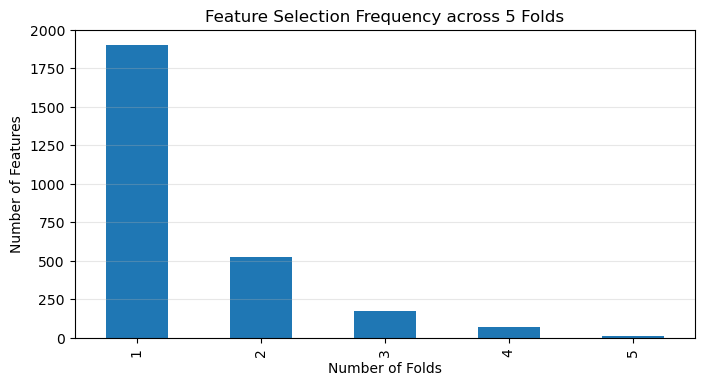

Features in ALL 5 folds: 13


In [64]:
stability_df = analyze_feature_stability(cv_results)
n_folds = 5
stable_in_all = stability_df[stability_df['Frequency'] == n_folds]
print("\nTop Stable Features (Selected across multiple folds):")
print(stability_df.head(5))


plt.figure(figsize=(8, 4))
stability_df['Frequency'].value_counts().sort_index().plot(kind='bar')
plt.title('Feature Selection Frequency across 5 Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Number of Features')
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/roc_curve_{bin_size}_fold.png")
plt.show()
print(f"Features in ALL 5 folds: {len(stable_in_all)}")

In [65]:
print(simple_feature_names)
print(pars_overlap)

{'mean_chr16_23800000', 'mean_chr4_40150000', 'stdev_chr5_96800000', 'mean_chr9_6700000', 'stdev_chr17_48700000', 'mean_chr12_123900000', 'stdev_chr20_18450000', 'stdev_chr2_196900000', 'mean_chr7_149100000', 'mean_chr20_47950000', 'stdev_chr1_51700000', 'stdev_chr2_105300000', 'mean_chr14_103300000', 'stdev_chr5_126750000', 'mean_chr4_20250000', 'stdev_chr17_60300000', 'stdev_chr18_48400000', 'stdev_chr8_138450000', 'stdev_chr1_206300000', 'mean_chr17_78350000', 'mean_chr9_124250000', 'mean_chr11_122100000', 'mean_chr17_83200000', 'stdev_chr21_39400000', 'stdev_chr2_218650000', 'stdev_chr11_550000', 'mean_chr1_13050000', 'stdev_chr1_151150000', 'mean_chr1_248650000', 'mean_chr11_38600000', 'mean_chr12_31050000', 'mean_chr17_80200000', 'mean_chr1_148150000', 'mean_chr3_196550000', 'mean_chr3_97950000', 'mean_chr2_110700000', 'mean_chr11_1800000', 'stdev_chr12_86250000', 'mean_chr1_143950000', 'stdev_chr3_195400000', 'mean_chr1_219400000', 'mean_chr9_114200000', 'stdev_chr3_12100000', '

## 7.4 Feature Overlap Heatmap 


Text(0.5, 1.0, 'Feature Selection Consistency')

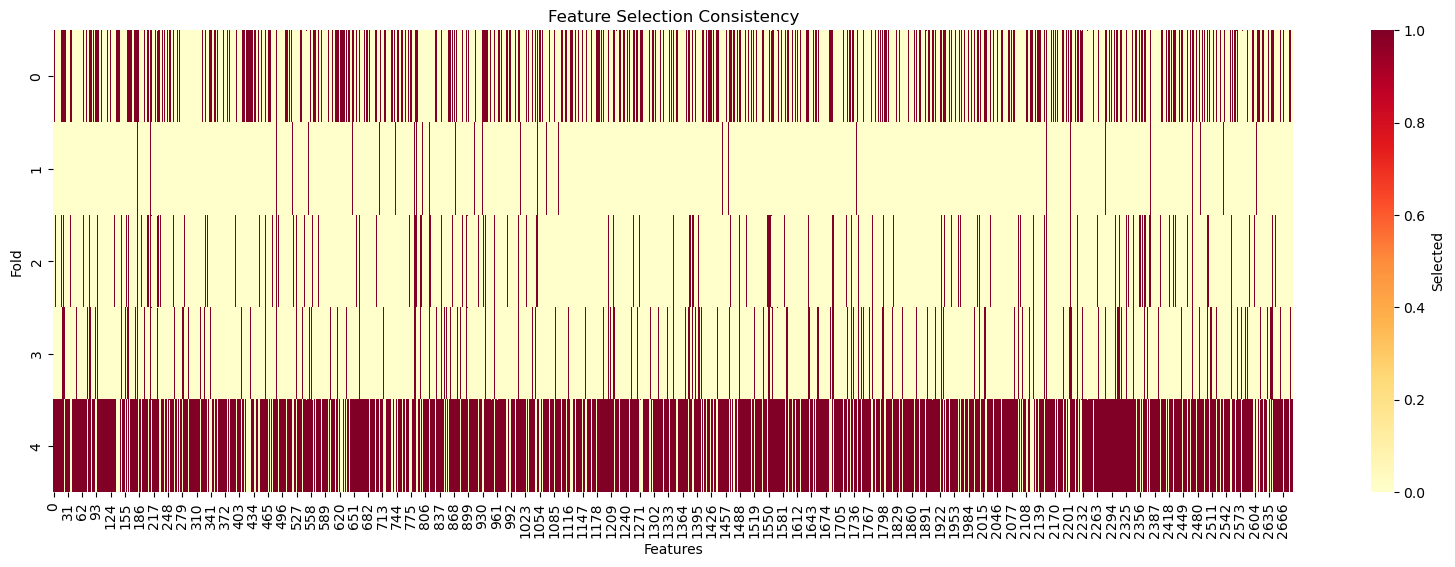

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

n_folds = len(cv_results)
all_features = set()
for e in cv_results:
    all_features.update(e['selected_features'].keys())

matrix = np.zeros((n_folds, len(all_features)))
for i, e in enumerate(cv_results):
    for j, feat in enumerate(all_features):
        if feat in e['selected_features']:
            matrix[i, j] = 1

plt.figure(figsize=(20, 6))
sns.heatmap(matrix, cmap='YlOrRd', cbar_kws={'label': 'Selected'})
plt.xlabel('Features')
plt.ylabel('Fold')
plt.title('Feature Selection Consistency')

## 7.5 Saving stable features in file for comparison

In [67]:
import pandas as pd
from itertools import combinations

def extract_genomic_position(feature):
    if 'chr' in feature:
        return feature[feature.index('chr'):]
    return feature

metrics = {
    "mean": "stable_features_['mean']_50000_fold.csv",
    "stdev": "stable_features_['stdev']_50000_fold.csv",
    "wps": "stable_features_['wps_value']_50000_fold.csv",
    "mean_median_stdev": "stable_features_['mean', 'median', 'stdev']_50000_fold.csv"
}

base_path = "/labmed/workspace/lotta/finaletoolkit/outputs/statistics/"

feature_sets = {}

for metric, file in metrics.items():
    df = pd.read_csv(base_path + file)
    cleaned = {extract_genomic_position(f) for f in df['Feature']}
    feature_sets[metric] = cleaned


for (m1, f1), (m2, f2) in combinations(feature_sets.items(), 2):
    intersection = f1 & f2
    print(
        f"Intersection between {m1} and {m2}: "
        f"{len(intersection)} stable features\n{intersection}\n"
    )


Intersection between mean and stdev: 4 stable features
{'chr1_202900000', 'chr1_248500000', 'chr6_20400000', 'chr7_149100000'}

Intersection between mean and wps: 8 stable features
{'chr17_75200000', 'chr8_8950000', 'chr8_60950000', 'chr17_4800000', 'chr1_30700000', 'chr18_3850000', 'chr1_2150000', 'chr1_1600000'}

Intersection between mean and mean_median_stdev: 7 stable features
{'chr9_135700000', 'chr19_6700000', 'chr16_28350000', 'chr2_222600000', 'chr7_63350000', 'chr1_235300000', 'chr15_43650000'}

Intersection between stdev and wps: 0 stable features
set()

Intersection between stdev and mean_median_stdev: 0 stable features
set()

Intersection between wps and mean_median_stdev: 0 stable features
set()



# 8. Visualize the ROC Calculation (Label, Probability)

In [68]:
# 1. Get the probabilities for the test set 
y_prob_test = pipeline.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame to map predictions to sample IDs
test_results = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': y_test,
    'Probability_Cancer': y_prob_test
})

# 3. Sort the results by probability    
test_results = test_results.sort_values(by='Probability_Cancer', ascending=False).reset_index(drop=True)

# 4. Print the top 5 predictions
print("Detailed predicitions for test set:")
print(test_results.head(5))


Detailed predicitions for test set:
  Sample_ID  True_Label  Probability_Cancer
0   EE87905           1            0.993105
1   EE87912           1            0.980038
2   EE87919           1            0.847645
3   EE87907           1            0.468250
4   EE87942           0            0.258951


In [69]:
# Falsch-Negative (Krebs als gesund vorhergesagt)
fn_proben = test_results[(test_results['True_Label'] == 1) & (test_results['Probability_Cancer'] < 0.3)]

# Falsch-Positive (Gesund als Krebs vorhergesagt)
fp_proben = test_results[(test_results['True_Label'] == 0) & (test_results['Probability_Cancer'] > 0.7)]

# Merge outliers with test_results to get the probabilities
outliers_meta = pd.concat([fn_proben, fp_proben])
if not outliers_meta.empty:
    ausreisser_klinik = clinical_df.merge(outliers_meta[['Sample_ID', 'Probability_Cancer', 'True_Label']], 
                                         left_on='Extracted_ID', right_on='Sample_ID')
    print(f"Found outliers with threshold (FN < 0.3, FP > 0.7): {len(ausreisser_klinik)}")
    print(ausreisser_klinik[['Extracted_ID', 'Patient Type', 'Gender', 'Probability_Cancer']])
else:
    print("No outliers found.")


Found outliers with threshold (FN < 0.3, FP > 0.7): 1
  Extracted_ID    Patient Type Gender  Probability_Cancer
0      EE87917  Gastric cancer      M            0.004273
